IMPORTING LIBRARIES

In [1]:
import os
import tempfile
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from functools import partial
from pathlib import Path
from torch.utils.data import random_split
from torchsummary import summary

GPU VERIFICATION

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LOAD, TRANSORM, AND AUGUMENT THE DATASET

In [3]:
transform_train = transforms.Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])
 
 
transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train) # Data augmentation is only done on training images
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True) # Batch size of 100 i.e to work with 100 images at a time
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


SIZE OF THE TRAINING AND VALIDATION BATCH

In [4]:
# Get a batch from each DataLoader and print their shapes
train_batch = next(iter(training_loader))
valid_batch = next(iter(validation_loader))

# Extract images and labels
train_images, train_labels = train_batch
valid_images, valid_labels = valid_batch

# Print the shapes
print(f"Train batch shape: {train_images.shape}")
print(f"Validation batch shape: {valid_images.shape}")

Train batch shape: torch.Size([100, 3, 32, 32])
Validation batch shape: torch.Size([100, 3, 32, 32])


CONVERTING IMAGES TO NUMPY ARRAYS

In [5]:
# We need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert(tensor):  
  image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

CLASS LABELS

In [6]:
# Different classes in CIPHAR 10 dataset. 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

PLOTTING TRAINING IMAGES

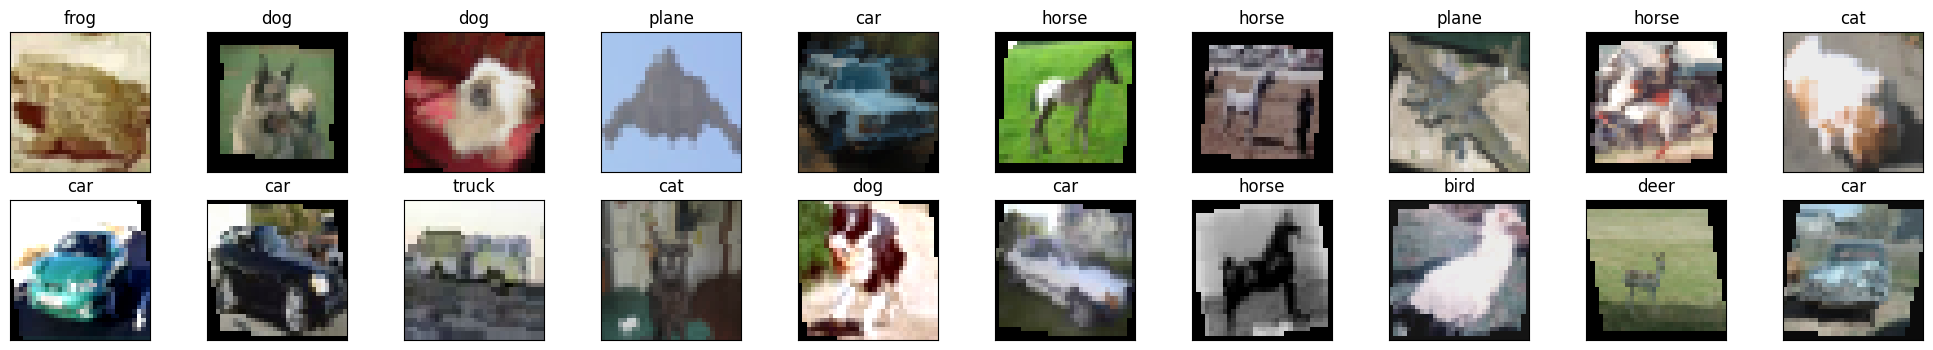

In [7]:
# We iterate the batch of images to display
dataiter = iter(training_loader)  # Converting our train_dataloader to iterable so that we can iterate through it
images, labels = next(dataiter)  # Using the built-in next() function
fig = plt.figure(figsize=(25, 4)) 

# We plot 20 images from our train_dataset
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[]) 
    plt.imshow(im_convert(images[idx]))  # Converting to numpy array as plt needs it
    ax.set_title(classes[labels[idx].item()])


CNN MODEL

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Convolutional Layers with Batch Normalization
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # Input channels: 3, Output channels: 64
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Input channels: 64, Output channels: 128
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Input channels: 128, Output channels: 256
        self.bn3 = nn.BatchNorm2d(256)
        
        # Pooling Layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)  # Input size: 256x4x4, Output size: 1024
        self.bn_fc1 = nn.BatchNorm1d(1024)
        
        self.fc2 = nn.Linear(1024, 10)  # Output size: 10 (number of classes)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten the image
        x = x.view(-1, 256 * 4 * 4)
        
        # Fully connected layers with Batch Normalization
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

RUNNING IN GPU

In [9]:
model = CNN().to(device) # run our model on cuda GPU for faster results
model

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (bn_fc1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

OPTIMIZER AND CRITERION

In [10]:
criterion = nn.CrossEntropyLoss() # same as categorical_crossentropy loss used in Keras models which runs on Tensorflow
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # fine tuned the lr

TRAINING THE DATA

In [11]:
import torch

# Define parameters
epochs = 20  # Set higher number of epochs
patience = 5  # Number of epochs with no improvement before stopping
best_val_loss = float('inf')  # Initialize best validation loss to infinity
patience_counter = 0  # Counter for early stopping

running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):  # Training our model for 'epochs' times
  
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
  
    # Training phase
    for inputs, labels in training_loader:
        inputs = inputs.to(device)  # Input to device
        labels = labels.to(device)
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        
        optimizer.zero_grad()  # Set gradients to zero
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        _, preds = torch.max(outputs, 1)  # Get predicted class
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)  # Count correct predictions

    # Validation phase
    with torch.no_grad():  # No gradient needed for validation
        for val_inputs, val_labels in validation_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            
            _, val_preds = torch.max(val_outputs, 1)
            val_running_loss += val_loss.item()
            val_running_corrects += torch.sum(val_preds == val_labels.data)
    
    # Calculate epoch loss and accuracy for training and validation
    epoch_loss = running_loss / len(training_loader)
    epoch_acc = running_corrects.float() / len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss / len(validation_loader)
    val_epoch_acc = val_running_corrects.float() / len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    
    print(f"Epoch: {e+1}")
    print(f"Training loss: {epoch_loss:.4f}, Training accuracy: {epoch_acc:.4f}")
    print(f"Validation loss: {val_epoch_loss:.4f}, Validation accuracy: {val_epoch_acc:.4f}")
    
    # Early stopping based on validation loss
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        patience_counter = 0  # Reset patience counter if improvement
    else:
        patience_counter += 1
    
    # Stop training if no improvement in validation loss for 'patience' epochs
    if patience_counter >= patience:
        print("Early stopping triggered. No improvement in validation loss for {} epochs.".format(patience))
        break

Epoch: 1
Training loss: 1.3055, Training accuracy: 53.2960
Validation loss: 0.9784, Validation accuracy: 65.4400
Epoch: 2
Training loss: 0.9809, Training accuracy: 65.4600
Validation loss: 0.8011, Validation accuracy: 72.0600
Epoch: 3
Training loss: 0.8616, Training accuracy: 69.6460
Validation loss: 0.7425, Validation accuracy: 74.3000
Epoch: 4
Training loss: 0.7875, Training accuracy: 72.3540
Validation loss: 0.6966, Validation accuracy: 75.7600
Epoch: 5
Training loss: 0.7307, Training accuracy: 74.3800
Validation loss: 0.6442, Validation accuracy: 77.3400
Epoch: 6
Training loss: 0.6857, Training accuracy: 76.0820
Validation loss: 0.6333, Validation accuracy: 78.0400
Epoch: 7
Training loss: 0.6520, Training accuracy: 77.0800
Validation loss: 0.6088, Validation accuracy: 79.0400
Epoch: 8
Training loss: 0.6240, Training accuracy: 78.0820
Validation loss: 0.5844, Validation accuracy: 79.8600
Epoch: 9
Training loss: 0.5919, Training accuracy: 79.4320
Validation loss: 0.5777, Validation a

SAVING THE MODEL

In [12]:
# Save the best model based on validation loss
torch.save(model.state_dict(), 'best_model.pth')

GRID SEARCH HYPERPARAMETER TUNING

In [38]:
import optuna
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameter space for tuning
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)  # Log-uniform distribution for learning rate
    batch_size = trial.suggest_categorical('batch_size', [64, 128])  # Categorical distribution for batch size
    
    criterion = nn.CrossEntropyLoss()  # Same loss function as before
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Adam optimizer with dynamically selected lr
    
    training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    
    # Early stopping parameters
    patience_counter = 0
    best_val_loss = float('inf')
    
    # Reset history for every trial run
    for e in range(10):
        running_loss = 0.0
        running_corrects = 0.0
        val_running_loss = 0.0
        val_running_corrects = 0.0
        
        # Training phase
        model.train()
        for inputs, labels in training_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
        
        # Calculate epoch loss and accuracy for training and validation
        epoch_loss = running_loss / len(training_loader)
        val_epoch_loss = val_running_loss / len(validation_loader)
        # Correct accuracy calculation per epoch
        epoch_acc = running_corrects.float() / len(training_loader.dataset)  # Divide by total number of samples in training dataset
        val_epoch_acc = val_running_corrects.float() / len(validation_loader.dataset)  # Divide by total number of samples in validation dataset

        
        # Early stopping based on validation loss
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping triggered. No improvement in validation loss for {patience} epochs.")
            break
        
        # Print results for each epoch within the trial
        print(f"Trial {trial.number}, Epoch {e+1}:")
        print(f"Training loss: {epoch_loss:.4f}, Training accuracy: {epoch_acc:.4f}")
        print(f"Validation loss: {val_epoch_loss:.4f}, Validation accuracy: {val_epoch_acc:.4f}")
    
    return best_val_loss  # Return the validation loss as the optimization objective

# Create Optuna study for Bayesian optimization
study = optuna.create_study(direction='minimize')  # Minimize validation loss
study.optimize(objective, n_trials=5)  # Run the optimization for 50 trials

# Print the best hyperparameters and corresponding model
best_params = study.best_params
print(f"Best model found with hyperparameters: {best_params}")


[I 2024-12-20 17:04:39,306] A new study created in memory with name: no-name-9f456907-05e9-48b0-b6e1-92ee4b42e2fd
C:\Users\7501\AppData\Local\Temp\ipykernel_25952\2516775874.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)  # Log-uniform distribution for learning rate


Trial 0, Epoch 1:
Training loss: 0.3692, Training accuracy: 0.8707
Validation loss: 0.4165, Validation accuracy: 0.8613
Trial 0, Epoch 2:
Training loss: 0.3585, Training accuracy: 0.8752
Validation loss: 0.4078, Validation accuracy: 0.8664
Trial 0, Epoch 3:
Training loss: 0.3426, Training accuracy: 0.8804
Validation loss: 0.4180, Validation accuracy: 0.8632
Trial 0, Epoch 4:
Training loss: 0.3379, Training accuracy: 0.8817
Validation loss: 0.4065, Validation accuracy: 0.8662
Trial 0, Epoch 5:
Training loss: 0.3309, Training accuracy: 0.8842
Validation loss: 0.4210, Validation accuracy: 0.8652
Trial 0, Epoch 6:
Training loss: 0.3188, Training accuracy: 0.8875
Validation loss: 0.4155, Validation accuracy: 0.8713
Trial 0, Epoch 7:
Training loss: 0.3142, Training accuracy: 0.8884
Validation loss: 0.4092, Validation accuracy: 0.8682
Trial 0, Epoch 8:
Training loss: 0.3062, Training accuracy: 0.8921
Validation loss: 0.4087, Validation accuracy: 0.8720


[I 2024-12-20 17:25:41,042] Trial 0 finished with value: 0.4065436688578053 and parameters: {'lr': 0.0007574535398532696, 'batch_size': 64}. Best is trial 0 with value: 0.4065436688578053.


Early stopping triggered. No improvement in validation loss for 5 epochs.
Trial 1, Epoch 1:
Training loss: 0.2625, Training accuracy: 0.9083
Validation loss: 0.3901, Validation accuracy: 0.8768
Trial 1, Epoch 2:
Training loss: 0.2569, Training accuracy: 0.9096
Validation loss: 0.3806, Validation accuracy: 0.8798
Trial 1, Epoch 3:
Training loss: 0.2474, Training accuracy: 0.9128
Validation loss: 0.3809, Validation accuracy: 0.8802
Trial 1, Epoch 4:
Training loss: 0.2372, Training accuracy: 0.9165
Validation loss: 0.3932, Validation accuracy: 0.8798
Trial 1, Epoch 5:
Training loss: 0.2345, Training accuracy: 0.9186
Validation loss: 0.3889, Validation accuracy: 0.8794
Trial 1, Epoch 6:
Training loss: 0.2322, Training accuracy: 0.9178
Validation loss: 0.3841, Validation accuracy: 0.8832


[I 2024-12-20 17:32:11,850] Trial 1 finished with value: 0.38063958534009895 and parameters: {'lr': 0.00016750014098488442, 'batch_size': 64}. Best is trial 1 with value: 0.38063958534009895.


Early stopping triggered. No improvement in validation loss for 5 epochs.
Trial 2, Epoch 1:
Training loss: 0.2044, Training accuracy: 0.9289
Validation loss: 0.3788, Validation accuracy: 0.8832
Trial 2, Epoch 2:
Training loss: 0.1991, Training accuracy: 0.9300
Validation loss: 0.3794, Validation accuracy: 0.8835
Trial 2, Epoch 3:
Training loss: 0.1961, Training accuracy: 0.9317
Validation loss: 0.3850, Validation accuracy: 0.8836
Trial 2, Epoch 4:
Training loss: 0.1945, Training accuracy: 0.9327
Validation loss: 0.3822, Validation accuracy: 0.8829
Trial 2, Epoch 5:
Training loss: 0.1947, Training accuracy: 0.9326
Validation loss: 0.3861, Validation accuracy: 0.8835


[I 2024-12-20 17:37:24,397] Trial 2 finished with value: 0.37883165686190884 and parameters: {'lr': 0.00010630707778002385, 'batch_size': 128}. Best is trial 2 with value: 0.37883165686190884.


Early stopping triggered. No improvement in validation loss for 5 epochs.
Trial 3, Epoch 1:
Training loss: 0.2088, Training accuracy: 0.9271
Validation loss: 0.3914, Validation accuracy: 0.8827
Trial 3, Epoch 2:
Training loss: 0.2053, Training accuracy: 0.9282
Validation loss: 0.3920, Validation accuracy: 0.8834
Trial 3, Epoch 3:
Training loss: 0.2055, Training accuracy: 0.9283
Validation loss: 0.3889, Validation accuracy: 0.8842
Trial 3, Epoch 4:
Training loss: 0.2021, Training accuracy: 0.9276
Validation loss: 0.3926, Validation accuracy: 0.8843
Trial 3, Epoch 5:
Training loss: 0.2015, Training accuracy: 0.9291
Validation loss: 0.3936, Validation accuracy: 0.8834
Trial 3, Epoch 6:
Training loss: 0.2009, Training accuracy: 0.9297
Validation loss: 0.3915, Validation accuracy: 0.8835
Trial 3, Epoch 7:
Training loss: 0.1978, Training accuracy: 0.9307
Validation loss: 0.3895, Validation accuracy: 0.8845


[I 2024-12-20 17:45:15,432] Trial 3 finished with value: 0.3888895948696288 and parameters: {'lr': 5.8251980832074273e-05, 'batch_size': 64}. Best is trial 2 with value: 0.37883165686190884.


Early stopping triggered. No improvement in validation loss for 5 epochs.
Trial 4, Epoch 1:
Training loss: 0.1817, Training accuracy: 0.9370
Validation loss: 0.3905, Validation accuracy: 0.8839
Trial 4, Epoch 2:
Training loss: 0.1799, Training accuracy: 0.9367
Validation loss: 0.3889, Validation accuracy: 0.8842
Trial 4, Epoch 3:
Training loss: 0.1829, Training accuracy: 0.9355
Validation loss: 0.3961, Validation accuracy: 0.8822
Trial 4, Epoch 4:
Training loss: 0.1851, Training accuracy: 0.9341
Validation loss: 0.3906, Validation accuracy: 0.8849
Trial 4, Epoch 5:
Training loss: 0.1803, Training accuracy: 0.9369
Validation loss: 0.3891, Validation accuracy: 0.8844
Trial 4, Epoch 6:
Training loss: 0.1799, Training accuracy: 0.9369
Validation loss: 0.3888, Validation accuracy: 0.8850
Trial 4, Epoch 7:
Training loss: 0.1767, Training accuracy: 0.9382
Validation loss: 0.3925, Validation accuracy: 0.8850
Trial 4, Epoch 8:
Training loss: 0.1748, Training accuracy: 0.9390
Validation loss: 0.

[I 2024-12-20 17:54:07,506] Trial 4 finished with value: 0.3888290379243561 and parameters: {'lr': 0.0001418611785888186, 'batch_size': 128}. Best is trial 2 with value: 0.37883165686190884.


Trial 4, Epoch 10:
Training loss: 0.1710, Training accuracy: 0.9400
Validation loss: 0.3937, Validation accuracy: 0.8866
Best model found with hyperparameters: {'lr': 0.00010630707778002385, 'batch_size': 128}


TRAINING THE MODEL ON BEST PARAMETERS (lr = 0.00010630707778002385, batch_size = 128)

In [11]:
import torch
import os

# Define parameters
epochs = 20
patience = 5
best_val_loss = float('inf')
best_val_acc = 0.0
patience_counter = 0

running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=128, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=128, shuffle=False)
num_train_samples = len(training_loader.dataset)
num_val_samples = len(validation_loader.dataset)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00010630707778002385)

for e in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    # Training phase
    model.train()
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # Validation phase
    model.eval()
    with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            
            _, val_preds = torch.max(val_outputs, 1)
            val_running_loss += val_loss.item() * val_inputs.size(0)
            val_running_corrects += torch.sum(val_preds == val_labels.data)

    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / num_train_samples
    epoch_acc = (running_corrects.float() / num_train_samples) * 100
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss / num_val_samples
    val_epoch_acc = (val_running_corrects.float() / num_val_samples) * 100
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    
    print(f"Epoch: {e+1}")
    print(f"Training loss: {epoch_loss:.4f}, Training accuracy: {epoch_acc:.2f}%")
    print(f"Validation loss: {val_epoch_loss:.4f}, Validation accuracy: {val_epoch_acc:.2f}%")
    
    # Save model with the best validation accuracy and loss
    if val_epoch_loss < best_val_loss or val_epoch_acc > best_val_acc:
        best_val_loss = val_epoch_loss
        best_val_acc = val_epoch_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_final.pth")  # Save only the state_dict for easy loading
        print(f"Model saved with validation loss: {best_val_loss:.4f} and accuracy: {best_val_acc:.2f}%")
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("Early stopping triggered. No improvement in validation loss for {} epochs.".format(patience))
        break


Epoch: 1
Training loss: 1.4162, Training accuracy: 49.54%
Validation loss: 1.0540, Validation accuracy: 62.80%
Model saved with validation loss: 1.0540 and accuracy: 62.80%
Epoch: 2
Training loss: 1.1120, Training accuracy: 60.88%
Validation loss: 0.9372, Validation accuracy: 67.14%
Model saved with validation loss: 0.9372 and accuracy: 67.14%
Epoch: 3
Training loss: 1.0025, Training accuracy: 64.72%
Validation loss: 0.8533, Validation accuracy: 70.11%
Model saved with validation loss: 0.8533 and accuracy: 70.11%
Epoch: 4
Training loss: 0.9316, Training accuracy: 67.18%
Validation loss: 0.8173, Validation accuracy: 71.76%
Model saved with validation loss: 0.8173 and accuracy: 71.76%
Epoch: 5
Training loss: 0.8779, Training accuracy: 69.11%
Validation loss: 0.7618, Validation accuracy: 73.51%
Model saved with validation loss: 0.7618 and accuracy: 73.51%
Epoch: 6
Training loss: 0.8316, Training accuracy: 70.74%
Validation loss: 0.7144, Validation accuracy: 75.20%
Model saved with validat

VALIDATION ACCURACY MEASURES

In [17]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

# Load the model
model = CNN()  # Replace with your actual model class
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # Set model to evaluation mode
model.to(device)  # Move model to the correct device (CPU or GPU)

# Initialize variables to store results
all_preds = []
all_labels = []
val_loss = 0.0
val_corrects = 0.0

# Validation phase (no gradient needed)
with torch.no_grad():  # No gradient computation for validation
    for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        
        # Calculate validation loss
        loss = criterion(val_outputs, val_labels)
        val_loss += loss.item() * val_inputs.size(0)  # Multiply by batch size
        
        # Get predicted classes
        _, preds = torch.max(val_outputs, 1)
        
        # Count correct predictions
        val_corrects += torch.sum(preds == val_labels.data)
        
        # Store predictions and labels for metrics calculation
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(val_labels.cpu().numpy())

# Calculate final validation loss and accuracy
num_val_samples = len(validation_loader.dataset)  # Total number of validation samples
final_val_loss = val_loss / num_val_samples
final_val_acc = (val_corrects.float() / num_val_samples) * 100  # Convert to percentage

# Calculate Precision, Recall, and F1 Score
final_precision = precision_score(all_labels, all_preds, average='weighted')
final_recall = recall_score(all_labels, all_preds, average='weighted')
final_f1 = f1_score(all_labels, all_preds, average='weighted')

# Display the results
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")
print(f"Final Precision: {final_precision:.4f}")
print(f"Final Recall: {final_recall:.4f}")
print(f"Final F1 Score: {final_f1:.4f}")


C:\Users\7501\AppData\Local\Temp\ipykernel_25568\3640105879.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Final Validation Loss: 0.4204
Final Validation Accuracy: 85.91%
Final Precision: 0.8584
Final Recall: 0.8591
Final F1 Score: 0.8581


In [37]:
# Assuming you have your trained model
model = CNN()

# After training, save the model with the best weights (best_model.pth)
torch.save(model.state_dict(), 'best_model.pth')

PLOTTING TRAINING Vs VALIDATION LOSS/ACCURACY

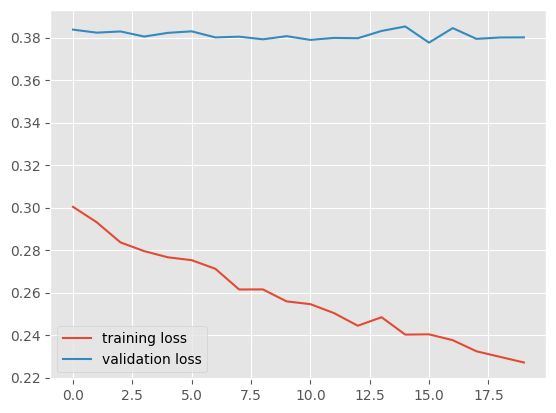

In [19]:
plt.style.use('ggplot')
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

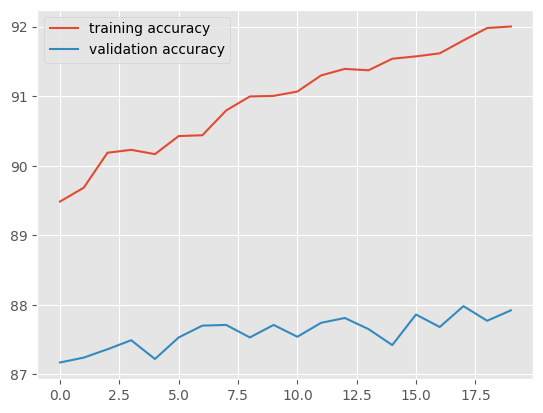

In [20]:
plt.style.use('ggplot')

# Convert tensors to CPU and then to NumPy
training_accuracy = [acc.cpu().numpy() for acc in running_corrects_history]
validation_accuracy = [acc.cpu().numpy() for acc in val_running_corrects_history]

# Plot the training and validation accuracy
plt.plot(training_accuracy, label='training accuracy')
plt.plot(validation_accuracy, label='validation accuracy')
plt.legend()
plt.show()


TEST ACCURACY AND LOSS

In [24]:
# Define transformations for the test dataset
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std
])

# Load the test dataset
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

# Define the test loader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Define the test loader

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()  # Set the model to evaluation mode
model.to(device)  # Ensure the model is on the correct device

# Iterate over the test data
for data, target in test_loader:
    # Move tensors to the GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    
    # Forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    
    # Calculate the batch loss
    loss = criterion(output, target)
    
    # Update the total test loss
    test_loss += loss.item() * data.size(0)
    
    # Convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    
    # Compare predictions to true labels
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = correct_tensor.cpu().numpy().squeeze()
    
    # Calculate test accuracy for each class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i]
        class_total[label] += 1

# Average test loss
test_loss = test_loss / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.6f}\n')

# Display accuracy for each class
for i in range(10):
    if class_total[i] > 0:
        accuracy = 100.0 * class_correct[i] / class_total[i]
        print(f'Test Accuracy of {classes[i]:>5s}: {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
    else:
        print(f'Test Accuracy of {classes[i]:>5s}: N/A (no test examples)')

# Display overall test accuracy
overall_accuracy = 100.0 * sum(class_correct) / sum(class_total)
print(f'\nTest Accuracy (Overall): {overall_accuracy:.2f}% ({int(sum(class_correct))}/{int(sum(class_total))})')


Files already downloaded and verified
Test Loss: 0.420391

Test Accuracy of plane: 87.70% (877/1000)
Test Accuracy of   car: 93.40% (934/1000)
Test Accuracy of  bird: 81.50% (815/1000)
Test Accuracy of   cat: 67.10% (671/1000)
Test Accuracy of  deer: 87.80% (878/1000)
Test Accuracy of   dog: 79.00% (790/1000)
Test Accuracy of  frog: 92.40% (924/1000)
Test Accuracy of horse: 90.00% (900/1000)
Test Accuracy of  ship: 91.50% (915/1000)
Test Accuracy of truck: 88.70% (887/1000)

Test Accuracy (Overall): 85.91% (8591/10000)


TRUE Vs PREDICTED LABELS

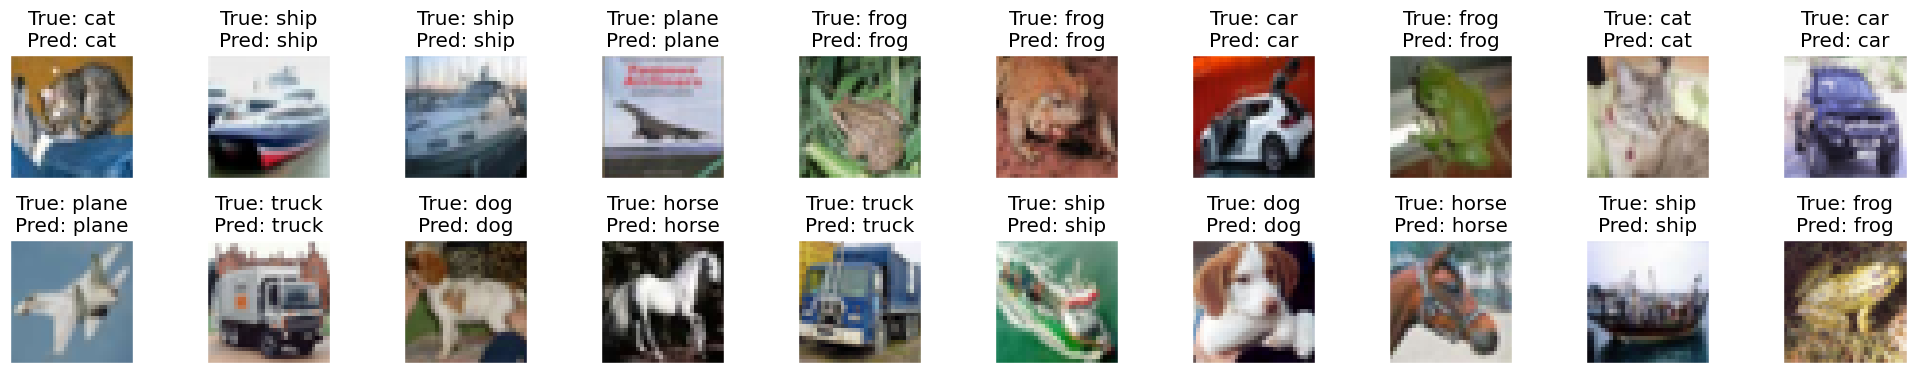

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# We iterate the batch of images to display
dataiter = iter(test_loader)  # Converting test_loader to iterable so that we can iterate through it
images, labels = next(dataiter)  # Using the built-in next() function
fig = plt.figure(figsize=(25, 4))  # Set figure size

# Predict the class labels for these images
output = model(images.to(device))  # Forward pass to get the model predictions
_, preds = torch.max(output, 1)  # Get the class with the highest probability

# Convert labels and predictions to their class names
true_labels = [classes[labels[j]] for j in range(len(labels))]
pred_labels = [classes[preds[j]] for j in range(len(preds))]

# We plot 20 images from the test dataset
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[]) 
    plt.imshow(np.transpose(images[idx] / 2 + 0.5, (1, 2, 0)))  # Unnormalize and convert to numpy array
    ax.set_title(f'True: {true_labels[idx]}\nPred: {pred_labels[idx]}')

# Adjust the layout to add gap between rows
plt.subplots_adjust(hspace=0.5)  # Add vertical space between rows

plt.show()


CPU Vs GPU LATENCIES

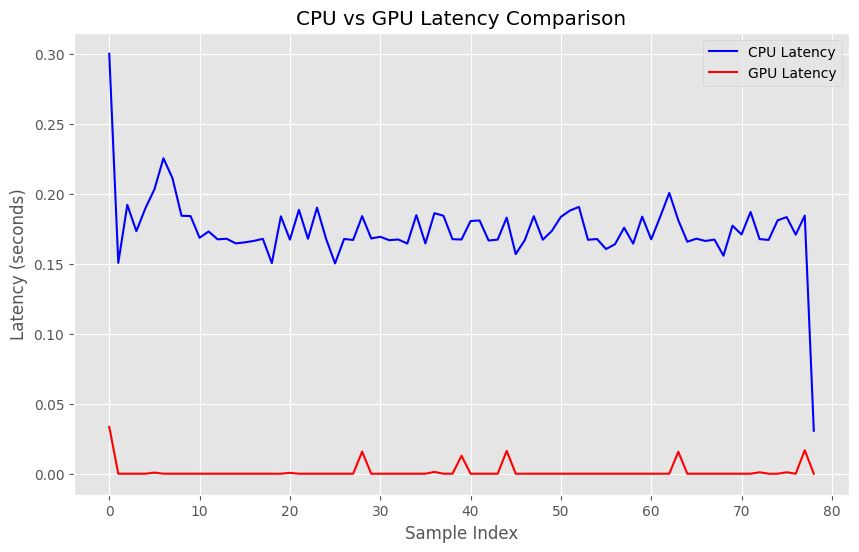

Average latency on CPU: 0.174345 seconds
Average latency on GPU: 0.001464 seconds


In [35]:
import time
def measure_latency(loader, device):
    latencies = []
    model.to(device)  # Move model to the specified device
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            start_time = time.time()
            model(data)
            latencies.append(time.time() - start_time)
    return latencies

# Measure latency on CPU
cpu_latencies = measure_latency(validation_loader, 'cpu')

# Measure latency on GPU (if available)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gpu_latencies = measure_latency(validation_loader, device)

# Plot the comparison of latencies
plt.figure(figsize=(10, 6))
plt.plot(cpu_latencies, label='CPU Latency', color='blue')
plt.plot(gpu_latencies, label='GPU Latency', color='red')
plt.xlabel('Sample Index')
plt.ylabel('Latency (seconds)')
plt.title('CPU vs GPU Latency Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Print the average latencies
print(f"Average latency on CPU: {sum(cpu_latencies)/len(cpu_latencies):.6f} seconds")
print(f"Average latency on GPU: {sum(gpu_latencies)/len(gpu_latencies):.6f} seconds")